# Poseidon Project

The sailboat model implemented in this notebook is based on the system presented in [Sliding Mode Control of An Autonomous Sailboat](https://www.researchgate.net/publication/326294162).

The model uses the *North-East-Down (NED)* coordinate system as inertial reference frame (*n-frame*). The body fixed frame (*b-frame*) is defined as a rotating frame as indicated in the following figure.

![figure1](./images/sailboat.png)
<center><b>Figure 1: </b> <i> Sailboat model reference frames and variables </i></center>

## Functions
---

**`sailboat_model(z0::Array{Float64,1}, dot_δs::Float64, dot_δr::Float64, vw::Float64, γw::Float64, vc::Float64, ϕc::Float64)`**

Compute the states of the sailboat model according to the input commands `dot_δs` and `dot_δr`.

Model states:

`z[1]` : world `x` position [m]

`z[2]` : world `y` position [m]

`z[3]` : speed `u` [m/s]

`z[4]` : north-heading `ψ` [rad]

`z[5]` : heading rate `r` [rad/s]

`z[6]` : sail deflection wrt x-axis of body frame `δs` [rad]

`z[7]` : rudder deflection wrt x-axis of body frame `δr` [rad]


*Arguments:*

- `z0::Array{Float64,1}` : initial conditions of the system
- `dot_δs::Float64` : sail deflection rate wrt x-axis of body frame [rad]
- `dot_δr::Float64` : rudder deflection rate wrt x-axis of body frame [rad/s]
- `vw::Float64` : wind speed [m/s]
- `γw::Float64` : wind north-heading [rad]
- `vc::Float64` : maritime current speed [m/s]
- `ϕc::Float64` : maritime current north-heading [rad]

*Return:*

A vector `dot_z::Array{Float64,1}` with the derivatives of states of the system.

---

**`sailboat_smc(zref::Array{Float64,1}, z::Array{Float64,1}, vw::Float64, γw::Float64, vc::Float64, ϕc::Float64)`**

Compute the commands `dot_δs` and `dot_δr` according to the reference state `zref::Array{Float64,1}` and the current state of the system `z::Array{Float64,1}`.

*Return:*

A vector `cmd::Array{Float64,1}` with the sail and rudder rates commands. 

![figure2](./images/variables-description.png)

In [86]:
using Plots
gr()

Plots.GRBackend()

In [122]:
function check_limits(z::Array{Float64,1})
   
    ψboat = z[3]
    z[3] = atan2(sin(ψboat), cos(ψboat))
    
    δrudder = z[5]
    if abs(δrudder) > 12*π/5
        z[5]  = sign(δrudder) * 12*π/5.
    end
    
    return z
    
end

function forces(z::Array{Float64,1}, vw::Float64, ϕw::Float64)

    z = check_limits(z)
    
    ψboat = z[3]
    δsail = z[4]
    δrudder = z[5]   
    uboat = z[6]
    
    fsail = λs * vw * cos(ψboat + δsail - ϕw) - λs * uboat * sin(δsail)
    frudder = λr * uboat * sin(δrudder)
    
    return fsail, frudder
    
end

function sailboat_model(z::Array{Float64,1}, cmd::Array{Float64,1}, vw::Float64, ϕw::Float64, 
                            vc::Float64, ϕc::Float64)

    z = check_limits(z)
    
    xboat  = z[1]
    yboat  = z[2]
    ψboat  = z[3]
    δsail = z[4]
    δrudder = z[5]    
    uboat  = z[6]
    rboat  = z[7]
    fsail, frudder = forces(z, vw, ϕw)

    dxboat  = uboat * cos(ψboat) + vc * cos(ϕc)
    dyboat  = uboat * sin(ψboat) + vc * sin(ϕc) - βb * vw
    dψboat  = rboat
    dδsail = cmd[1]
    dδrudder = cmd[2]
    duboat  = 1 / m * (fsail * sin(δsail) - frudder * sin(δrudder) - cfw_l * uboat)
    drboat  = 1 / Jz * ((ρmc - ρgm * cos(δsail)) * fsail - ρgr * frudder * cos(δrudder) - cfw_a * rboat)
    
    dz = [dxboat, dyboat, dψboat, dδsail, dδrudder, duboat, drboat]
        
    return dz
end

function heading_ref(q, xd, yd, ψref, x, y)
   
    ψref_tmp = atan2((yd-y),(xd-x))
    
    a = 20;
    
    if (q==3) && ((x-xd)>a)
        q = 4
    end
    
    if (q==4) && ((xd-x)>a)
        q = 3
    end
    
    if (q==3) && ((y-yd)>a)
        q = 1
    end
    
    if (q==1) && ((yd-y)>a)
        q = 3
    end
    
    if (q==1) && ((x-xd)>a)
        q = 2
    end
    
    if (q==2) && ((xd-x)>a)
        q = 1
    end
    
    if(q==4) && ((y-yd)>a)
        q = 2 
    end
    
    if(q==2) && ((yd-y)>a)
        q = 4
    end
    
    if q == 1
        ψref_tmp = 7*pi/4
    elseif  q ==2
        ψref_tmp = 5*pi/4
    elseif q == 3
        ψref_tmp = pi/6
    elseif q == 4
        ψref_tmp = 5*pi/6
    end
        
    ψref_tmp = ψref_tmp + 2 * π * round((ψref - ψref_tmp) / (2*π))
    ψref = ψref + (ψref_tmp - ψref) * dt
    
    return ψref, q    
end

function sail_ref(ψref)
    
    δsref = π * floor( ψref / (2*π) + 1/4) + π/4 - ψref/2
    δsref = atan2(sin(δsref), cos(δsref))
    
    return δsref
end

function r(z,w)
    
    ψboat  = z[3]
    δsail = z[4]
    δrudder = z[5]    
    uboat  = z[6]
    rboat  = z[7]
    fsail, frudder = forces(z, vw, ϕw)
    
    dψboat = rboat
    duboat  = 1 / m * (fsail * sin(δsail) - frudder * sin(δrudder) - cfw_l * uboat)
    drboat  = 1 / Jz * ((ρmc - ρgm * cos(δsail)) * fsail - ρgr * frudder * cos(δrudder) - cfw_a * rboat)
    
    A1 = [1. 0.; ρgm/Jz * fsail * sin(δsail) ρgr/Jz * frudder * sin(δrudder)];
    
    A2 = [0. 0.; ρmc/Jz - ρgm/Jz * cos(δsail) -ρgr/Jz * cos(δrudder)];
    
    A3 = [-λs * (vw * sin(ψboat + δsail) + uboat * cos(δsail)) 0.; 0. λr * uboat * cos(δrudder)];
    
    b1 = [0, -cfw_a/Jz * drboat];
    
    b2 = [-λs * (vw * rboat * sin(ψboat + δsail) + duboat * sin(δsail)), λr * duboat * sin(δrudder)];
    
    A  = A1 + A2 * A3;
    b  = A2 * b2 + b1;
    
    u  = inv(A) * ((w - [δsail, ψboat + 3 * rboat + 3 * drboat]) - b);
    
    return u
end

r (generic function with 1 method)

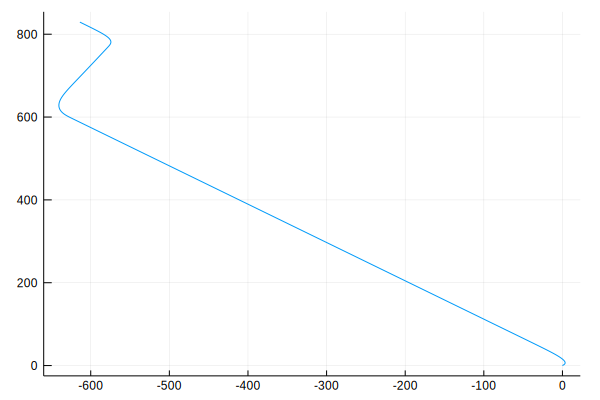

In [124]:
βb = 0.05   #boat’s drift coefficient
cfw_l = 60.  #water friction
cfw_a = 500. #water angular friction
λs  = 500.  #lift coefficient of the sail
λr  = 300.  #lift coefficient of the rudder
ρmc = 1.    #distance between the mast and the center of the sail
ρgm = 1.    #distance between the boat’s center of gravity and the mast
ρgr = 2.    #distance between G and the rudder
m   = 1000. #total mass of the boat (including the added-mass)
Jz  = 2000. #moment of inertia

vw = 10.  #wind speed
ϕw = 0.   #wind heading
vc = 0.  #water current speed, 
ϕc = 0.25 #water current heading

#initial conditions
x_ = [0.]
y_ = [0.]
ψ_ = [deg2rad(45.)]
δs_ = [deg2rad(67.5)]
δr_ = [deg2rad(3.9)]
u_ = [8.]
r_ = [0.]
z = [x_[end], y_[end], ψ_[end], δs_[end], δr_[end], u_[end], r_[end]]
z = check_limits(z)

#goal position
xd = 850.
yd = -600.
zd = [xd, yd, 0., 0., 0., 0., 0.]
ψd_ = [0.]
δsd_ = [0.]

fs_tmp, fr_tmp = forces(z, vw, ϕw)
fr_ = [fs_tmp]
fs_ = [fr_tmp]

err = norm([x_[end], y_[end]] - [xd, yd])
time_  = 0. 
dt = 0.1
q = 1

while err > 25 && time_ < 550.
    
    ψd_tmp, q = heading_ref(q, xd, yd, ψd_[end], x_[end], y_[end]);
    δsd_tmp = sail_ref(ψd_tmp)
    
    w = [δsd_tmp, ψd_tmp]
    cmd = r(z,w)
    #cmd = sailboat_smc(zd, z, vw, ϕw, vc, ϕc, ψd_tmp, δsd_tmp)
    z += sailboat_model(z, cmd, vw, ϕw, vc, ϕc) * dt
    
    push!(x_,z[1])
    push!(y_,z[2])
    push!(u_,z[3])
    push!(ψ_,z[4])
    push!(r_,z[5])
    push!(δs_,z[6])
    push!(δr_,z[7])
    push!(ψd_, ψd_tmp)
    push!(δsd_, δsd_tmp)
    
    fs_tmp, fr_tmp = forces(z, vw, ϕw)
    
    push!(fs_, fs_tmp)
    push!(fr_, fr_tmp)
    
    time_ = time_ + dt
    err = norm([x_[end], y_[end]] - [xd, yd])
end

plot(y_, x_, legend = false)